# MESSAGE-ix matrix improvement tool

This jupyter notebook is a prototype of the MESSAGE-ix matrix improvement tool.
This tool is aimed to automatically improve and optimize coefficient matrix quality for a MESSAGE-ix scenario and the used to return the results from scaled MESSAGE-ix matrix to the originally intended values.

This tool is derived from the tool developed by Makowski & Sosnowski, 1981 (https://pure.iiasa.ac.at/id/eprint/1766/1/CP-81-037.pdf)

According to Curtis and Reid (1972), matrix A can be described as well-scaled if:

$
\sum_{i} \sum_{j} \ (log_{10} \ |a_{i,j}|)^2 \leq v \qquad \qquad Eq. 1
$

with $v$ is an acceptable matrix quality criteria.
If $ax_{i,j}$ is $(log_{10} |a_{i,j}|)^2$ where $a_{i,j}$ is a non-zero value, matrix $Ax$ is:

In [2]:
import numpy as np
import pandas as pd
from pyomo.environ import *
from datetime import datetime
import xarray as xr

import matplotlib.pyplot as plt

def showme(df):
    return df["val"].unstack()

In [3]:
# Load the whole matrix
matrix      = (pd.read_csv('matrix_transport problem.csv')
               .set_index(['row','col'],drop=True)[['val']])

# create a binary matrix for optimization coefficient
matrix_sbin = matrix.copy()
matrix_sbin.loc[matrix_sbin['val']!=0,'val'] = 1
matrix_sbin = matrix_sbin.astype(int)

## converting matrix_sbin to dictiony
dict_matrix_sbin = matrix_sbin['val'].to_dict()


In [4]:
showme(matrix)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.8,2.500000e-09,1.400000e-08,1.7,2.5,1.8
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.000000e+00,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.000000e+00,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.000000e+00,1.000000e+00,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [5]:
showme(matrix_sbin)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.0,1.0,1.0,1.0,1.0,1.0
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.0,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.0,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.0,1.0,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [7]:
# calculate log base 2 of the absolute value of the matrix
log_absmatrix = matrix.copy()
log_absmatrix.loc[log_absmatrix['val']!=0,'val']=(np.log2(
    np.absolute(
        log_absmatrix.loc[log_absmatrix['val']!=0,'val'])))

log_absmatrix = showme(log_absmatrix)
log_absmatrix

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,0.0,0.847997,-28.575425,-26.089998,0.765535,1.321928,0.847997
demand(chicago),NaN,0.000000,NaN,NaN,0.000000,NaN,NaN
demand(new-york),NaN,NaN,0.000000,NaN,NaN,0.000000,NaN
demand(topeka),NaN,NaN,NaN,0.000000,NaN,NaN,0.000000
supply(san-diego),NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000


## Start Looping

In [66]:
RSFs = []
for row in log_absmatrix.index:
    rval = log_absmatrix.loc[row].fillna(0)
    lb,ub = min(rval),max(rval)
    mid = np.mean([lb,ub])
    RSFs += [2**(-mid)]

matrix0 = showme(matrix).mul(RSFs,axis=0)

In [67]:
log_absmatrix0 = np.log2(matrix0)
CSFs = []
for col in log_absmatrix0.columns:
    cval = log_absmatrix0[col].fillna(0)
    lb,ub = min(cval),max(cval)
    mid = np.mean([lb,ub])
    CSFs += [2**(-mid)]
new_matrix = showme(matrix).mul(row_scaler,axis=0).mul(CSFs,axis=1)

In [68]:
def report(text,df):
    print(f"{text}:","[",np.int32(np.min(np.log10(df))),",",np.int32(np.max(np.log10(df))),"]")
report("Original value",showme(matrix))
report("Row scaling val",matrix0)
report("New Matrix",new_matrix)

Original value: [ -8 , 0 ]
Row scaling val: [ -4 , 4 ]
New Matrix: [ -2 , 2 ]


In [69]:
showme(matrix)

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,1.0,1.8,2.500000e-09,1.400000e-08,1.7,2.5,1.8
demand(chicago),NaN,1.0,NaN,NaN,1.0,NaN,NaN
demand(new-york),NaN,NaN,1.000000e+00,NaN,NaN,1.0,NaN
demand(topeka),NaN,NaN,NaN,1.000000e+00,NaN,NaN,1.0
supply(san-diego),NaN,1.0,1.000000e+00,1.000000e+00,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.0,1.0,1.0


In [70]:
matrix0

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,12649.110641,22768.399153,0.000032,0.000177,21503.488089,31622.776602,22768.399153
demand(chicago),NaN,1.000000,NaN,NaN,1.000000,NaN,NaN
demand(new-york),NaN,NaN,1.000000,NaN,NaN,1.000000,NaN
demand(topeka),NaN,NaN,NaN,1.000000,NaN,NaN,1.000000
supply(san-diego),NaN,1.000000,1.000000,1.000000,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000


In [71]:
new_matrix

col,constobj,"x(san-diego,chicago)","x(san-diego,new-york)","x(san-diego,topeka)","x(seattle,chicago)","x(seattle,new-york)","x(seattle,topeka)"
row,,,,,,,
_obj,112.468265,150.892012,0.005623,0.013307,146.640677,177.827941,150.892012
demand(chicago),NaN,0.006627,NaN,NaN,0.006819,NaN,NaN
demand(new-york),NaN,NaN,177.827941,NaN,NaN,0.005623,NaN
demand(topeka),NaN,NaN,NaN,75.146020,NaN,NaN,0.006627
supply(san-diego),NaN,0.006627,177.827941,75.146020,NaN,NaN,NaN
supply(seattle),NaN,NaN,NaN,NaN,0.006819,0.005623,0.006627


In [72]:
scalers = [RSFs,CSFs]
prescale_args = {}
for s in scalers:
    for k,v in s.items():
        if k == '_obj':
            k_ = "_obj.scale"
        elif k == 'constobj':
            k_ = "constobj.scale"
        else:
            k_ = k.replace("(", ".scale('")
            k_ = k_.replace(")", "')")
            k_ = k_.replace(",", "','")
        prescale_args.update({k_:v})

gams_args = (str(prescale_args)
             .replace('{','')
             .replace('}','')
             .replace('"','')
             .replace(':','=')
             .replace(', ',';\n')
             +';'
            )

AttributeError: 'list' object has no attribute 'items'

In [12]:
print(gams_args)

demand.scale('new-york')= 2048.0;
'_obj.scale'= 1.0;
supply.scale('seattle')= 8.0;
supply.scale('san-diego')= 32768.0;
demand.scale('topeka')= 1024.0;
demand.scale('chicago')= 32.0;
x.scale('seattle','new-york')= 8.0;
x.scale('san-diego','topeka')= 262144.0;
x.scale('seattle','chicago')= 8.0;
x.scale('seattle','topeka')= 8.0;
x.scale('san-diego','chicago')= 128.0;
x.scale('san-diego','new-york')= 524288.0;
'constobj.scale'= 1.0;


In [13]:
np.log2(524288.0)

19.0

In [14]:
# Printing stats

matrices_dict = {'Old Matrix':matrix,
                 'New Matrix':new_matrix,
                } 

for k,v in matrices_dict.items():
    print(f'{k} stats:')
    print('>> log10 coefficient range:',
          np.floor(np.log10(np.abs(v['val'].unstack()).fillna(1)).min(axis=None)),'--',
          np.floor(np.log10(np.abs(v['val'].unstack()).fillna(1)).max(axis=None)))
    print('')

# TO DO:
# 1. plot histogram of log10 distribution of those matrix


Old Matrix stats:
>> log10 coefficient range: -9.0 -- 0.0

New Matrix stats:
>> log10 coefficient range: -3.0 -- 2.0



(array([ 2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 17.]),
 array([-8.60205999, -7.70205999, -6.80205999, -5.90205999, -5.00205999,
        -4.10205999, -3.20205999, -2.30205999, -1.40205999, -0.50205999,
         0.39794001]),
 <BarContainer object of 10 artists>)

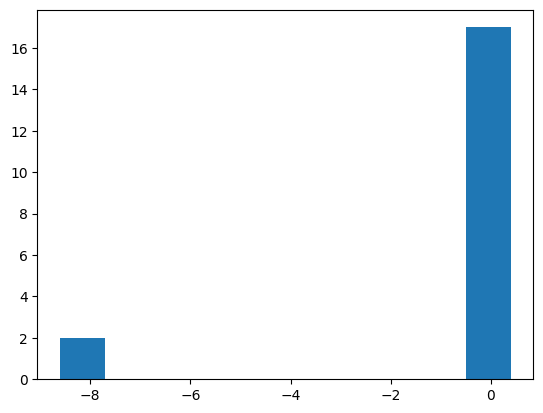

In [19]:
plt.hist(np.log10(matrix))

(array([4., 1., 0., 0., 1., 4., 1., 5., 0., 3.]),
 array([-2.88249007, -2.35341707, -1.82434407, -1.29527106, -0.76619806,
        -0.23712505,  0.29194795,  0.82102095,  1.35009396,  1.87916696,
         2.40823997]),
 <BarContainer object of 10 artists>)

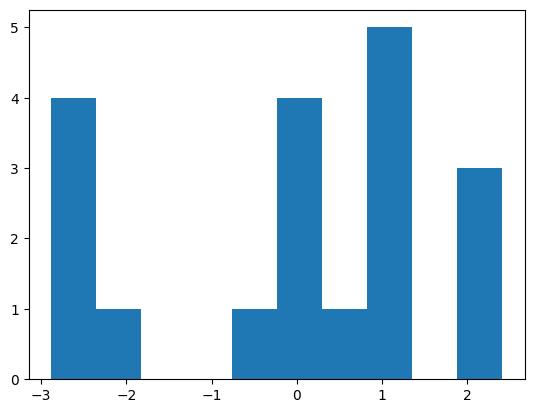

In [20]:
plt.hist(np.log10(new_matrix))